In [35]:
import keras
import datetime
import tensorflow                       as tf
from tensorflow.keras.callbacks         import TensorBoard
from tensorflow.keras.layers            import Input, Lambda,UpSampling2D, Conv2D,Dropout,MaxPooling2D,Conv2DTranspose,concatenate,BatchNormalization, Activation
from tensorflow.keras.models            import Model
from tensorflow.keras.optimizers        import Adam,RMSprop
from keras.utils                        import plot_model
from tensorflow.keras                   import layers, models
from tensorflow.keras.losses            import mae
import sys
import os
import numpy as np
import math
import random, time
from pathlib                        import Path
from PIL                            import Image

import skimage                      as ski
from   skimage.filters              import threshold_otsu
from   skimage                      import io, color
from   skimage.color                import rgb2gray
from   skimage                      import filters
import cv2                          as cv
import matplotlib.pyplot            as plt 
import gc
import glob
from skimage                        import img_as_ubyte
from skimage                        import io
import shutil
tf.keras.backend.clear_session()

In [36]:
os.environ["XLA_FLAGS"] = "--xla_gpu_strict_conv_algorithm_picker=false"

### Working with ImageDataGenerator

In [37]:
general_directory ='/home/ppgi/Trabajo/predicting-flow-patterns'
n_batch=8

def dataset(directory,batch_size=n_batch):
    data = keras.utils.image_dataset_from_directory(directory,
    labels=None,
    label_mode=None,
    image_size=(128, 256),
    color_mode="grayscale",
    shuffle=False,
    batch_size=batch_size)
    return data

path_1= general_directory + '/geo_masked' + '/train'
path_2= general_directory + '/geo_masked' + '/test'
path_3= general_directory + '/geo_masked' + '/valid'

path_4= general_directory + '/mag_masked' + '/train'
path_5= general_directory + '/mag_masked' + '/test'
path_6= general_directory + '/mag_masked' + '/valid'

path_7= general_directory + '/vx_masked' + '/train'
path_8= general_directory + '/vx_masked' + '/test'
path_9= general_directory + '/vx_masked' + '/valid'

path_10= general_directory + '/vy_masked' + '/train'
path_11= general_directory + '/vy_masked' + '/test'
path_12= general_directory + '/vy_masked' + '/valid'

path_13= general_directory + '/p_masked' + '/train'
path_14= general_directory + '/p_masked' + '/test'
path_15= general_directory + '/p_masked' + '/valid'
    

In [38]:
g_train = dataset(path_1)
g_test  = dataset(path_2)
g_valid = dataset(path_3)
print('******************')
v_train = dataset(path_4)
v_test  = dataset(path_5)
v_valid = dataset(path_6)
print('******************')
vx_train = dataset(path_7)
vx_test  = dataset(path_8)
vx_valid = dataset(path_9)
print('******************')
vy_train = dataset(path_10)
vy_test  = dataset(path_11)
vy_valid = dataset(path_12)
print('******************')
p_train = dataset(path_13)
p_test = dataset(path_14)
p_valid  = dataset(path_15)

Found 5600 files.
Found 800 files.
Found 1600 files.
******************
Found 5600 files.
Found 800 files.
Found 1600 files.
******************
Found 5600 files.
Found 800 files.
Found 1600 files.
******************
Found 5600 files.
Found 800 files.
Found 1600 files.
******************
Found 5600 files.
Found 800 files.
Found 1600 files.


In [48]:
print(type(p_valid))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [49]:
cardinality = tf.data.experimental.cardinality(p_valid).numpy()


In [50]:
cardinality

200

In [39]:
# combination of output datasets
output_train = tf.data.Dataset.zip((v_train,vx_train,vy_train,p_train))
output_test = tf.data.Dataset.zip((v_test,vx_test,vy_test,p_test))
output_valid = tf.data.Dataset.zip((v_valid,vx_valid,vy_valid,p_valid))

# combination of input datasets with output datasets
final_train = tf.data.Dataset.zip((g_train,output_train))
final_test = tf.data.Dataset.zip((g_test,output_test))
final_valid = tf.data.Dataset.zip((g_valid,output_valid))

### Standarize the data

In [40]:
# Standardizing values to be in the [0, 1] range by using tf.keras.layers.Rescaling:
normalization_layer = tf.keras.layers.Rescaling(1./255)

final_train_normalized = final_train.map(lambda x, y: (normalization_layer(x), y))
final_test_normalized = final_test.map(lambda x, y: (normalization_layer(x), y))
final_valid_normalized = final_valid.map(lambda x, y: (normalization_layer(x), y))


### Hiperparámeters

In [41]:
num_epochs = 10
patience=5  # How long to wait after last time validation loss improved
LR=0.001
# Model name
model_name="U-Net"
plot_name='U-Net_Model.png'
save_in='/home/ppgi/Trabajo/Codigos_generate_data/DLCODES-VER-5'
# image dimensions
img_width             =  256   # 739   G:737
img_height            =  128   # 185
channel               =  1

In [42]:
number_of_filters = [4, 46, 32]
type_padding = 'same'
f_activation = 'relu'
f_activation_last='linear'
optimizer = RMSprop(learning_rate=LR)
#number_of_filters = [16, 32, 64, 128, 256, 512]
#number_of_filters = [64, 128, 256, 512, 1024]

### Architecture

In [43]:
def conv_block_batchnorm(filters,x):
    conv = Conv2D(filters, (3, 3), padding=type_padding)(x)
    conv= BatchNormalization()(conv)
    conv = Activation(f_activation)(conv)
    conv = Conv2D(filters, (3, 3), padding=type_padding)(conv)
    conv= BatchNormalization()(conv)
    conv = Activation(f_activation)(conv)
    return conv
    
def conv_block(filters,x):
    conv = Conv2D(filters, (3, 3), activation=f_activation, padding=type_padding)(x)
    conv = Conv2D(filters, (3, 3), activation=f_activation, padding=type_padding)(conv)
    return conv    

def encoder(x,filters):
    conv = conv_block_batchnorm(filters,x)
    downsample = MaxPooling2D((2,2))(conv)
    return conv,downsample

def decoder(x1,x2,filters,transpose=None):
    if transpose != None:
        conv_up = Conv2DTranspose(filters,(2,2),strides=(2, 2),padding=type_padding)(x1)
    else:
        conv_up = UpSampling2D((2, 2))(x1)
   
    concat=concatenate([conv_up,x2],axis = 3)
    up = conv_block(filters, concat)
    return up


In [44]:
# number_of_filters = [16, 32, 64]
def make_model():
    
    image_input = Input((img_height, img_width, channel))
    
    conv1,down_block1 = encoder (image_input, number_of_filters[0])
    conv2,down_block2 = encoder (down_block1 , number_of_filters[1])

    bottleneck = conv_block(number_of_filters[2],down_block2)

    # First decoder
    up4 = decoder(bottleneck,conv2,number_of_filters[1])
    up5 = decoder(up4,conv1,number_of_filters[0])
    v_out = Conv2D(1, (1, 1), activation=f_activation_last,name='v_output')(up5)


    # Second decoder
    up4 = decoder(bottleneck,conv2,number_of_filters[1])
    up5 = decoder(up4,conv1,number_of_filters[0])
    vx_out = Conv2D(1, (1, 1), activation=f_activation_last,name='vx_output')(up5)

    # Third decoder
    up4 = decoder(bottleneck,conv2,number_of_filters[1])
    up5 = decoder(up4,conv1,number_of_filters[0])
    vy_out = Conv2D(1, (1, 1), activation=f_activation_last,name='vy_output')(up5)

    # Fourth decoder
    up4 = decoder(bottleneck,conv2,number_of_filters[1])
    up5 = decoder(up4,conv1,number_of_filters[0])
    p_out = Conv2D(1, (1, 1), activation=f_activation_last,name='p_output')(up5)
    
     # construct model
    model =  keras.Model(inputs=image_input, outputs=[v_out,vx_out,vy_out,p_out],name= model_name)
    
    model.summary()
    
    model.compile(optimizer=optimizer, 
              loss = {  'v_output': 'mean_squared_error' ,
                        'vx_output': 'mean_squared_error' , 
                        'vy_output': 'mean_squared_error',
                        'p_output': 'mean_squared_error'},
              
              metrics={ 'v_output': ['mae'],
                        'vx_output': ['mae'],
                        'vy_output': ['mae'],
                        'p_output': ['mae'] })
    return model    

In [45]:
'''
#number_of_filters = [16, 32, 64, 128, 256, 512]
def make_model():
    
    image_input = Input((img_height, img_width, channel))
    
    conv1,down_block1 = encoder (image_input, number_of_filters[0])
    conv2,down_block2 = encoder (down_block1 , number_of_filters[1])
    conv3,down_block3 = encoder (down_block2, number_of_filters[2])
    conv4,down_block4 = encoder (down_block3, number_of_filters[3])
    conv5,down_block5 = encoder (down_block4, number_of_filters[4])
    bottleneck = conv_block(number_of_filters[5],down_block5)
    # First decoder
    up6 = decoder(bottleneck,conv5,number_of_filters[4])
    up7 = decoder(up6,conv4,number_of_filters[3])
    up8 = decoder(up7,conv3,number_of_filters[2])
    up9 = decoder(up8,conv2,number_of_filters[1])
    up10 = decoder(up9,conv1,number_of_filters[0])
    v_out = Conv2D(1, (1, 1), activation=f_activation_last,name='v_output')(up10)

    # Second decoder
    up6 = decoder(bottleneck,conv5,number_of_filters[4])
    up7 = decoder(up6,conv4,number_of_filters[3])
    up8 = decoder(up7,conv3,number_of_filters[2])
    up9 = decoder(up8,conv2,number_of_filters[1])
    up10 = decoder(up9,conv1,number_of_filters[0])
    vx_out = Conv2D(1, (1, 1), activation=f_activation_last,name='vx_output')(up10)

    # Third decoder
    up6 = decoder(bottleneck,conv5,number_of_filters[4])
    up7 = decoder(up6,conv4,number_of_filters[3])
    up8 = decoder(up7,conv3,number_of_filters[2])
    up9 = decoder(up8,conv2,number_of_filters[1])
    up10 = decoder(up9,conv1,number_of_filters[0])
    vy_out = Conv2D(1, (1, 1), activation=f_activation_last,name='vy_output')(up10)

    # Fourth decoder
    up6 = decoder(bottleneck,conv5,number_of_filters[4])
    up7 = decoder(up6,conv4,number_of_filters[3])
    up8 = decoder(up7,conv3,number_of_filters[2])
    up9 = decoder(up8,conv2,number_of_filters[1])
    up10 = decoder(up9,conv1,number_of_filters[0])
    p_out = Conv2D(1, (1, 1), activation=f_activation_last,name='p_output')(up10)

    # construct model
    model =  keras.Model(inputs=image_input, outputs=[v_out,vx_out,vy_out,p_out],name= model_name)
    
    model.summary()
    
    model.compile(optimizer=optimizer, 
              loss = {  'v_output': 'mean_squared_error' ,
                        'vx_output': 'mean_squared_error' , 
                        'vy_output': 'mean_squared_error',
                        'p_output': 'mean_squared_error'},
              
              metrics={ 'v_output': ['mae'],
                        'vx_output': ['mae'],
                        'vy_output': ['mae'],
                        'p_output': ['mae'] })
    return model             
'''    

"\n#number_of_filters = [16, 32, 64, 128, 256, 512]\ndef make_model():\n    \n    image_input = Input((img_height, img_width, channel))\n    \n    conv1,down_block1 = encoder (image_input, number_of_filters[0])\n    conv2,down_block2 = encoder (down_block1 , number_of_filters[1])\n    conv3,down_block3 = encoder (down_block2, number_of_filters[2])\n    conv4,down_block4 = encoder (down_block3, number_of_filters[3])\n    conv5,down_block5 = encoder (down_block4, number_of_filters[4])\n    bottleneck = conv_block(number_of_filters[5],down_block5)\n    # First decoder\n    up6 = decoder(bottleneck,conv5,number_of_filters[4])\n    up7 = decoder(up6,conv4,number_of_filters[3])\n    up8 = decoder(up7,conv3,number_of_filters[2])\n    up9 = decoder(up8,conv2,number_of_filters[1])\n    up10 = decoder(up9,conv1,number_of_filters[0])\n    v_out = Conv2D(1, (1, 1), activation=f_activation_last,name='v_output')(up10)\n\n    # Second decoder\n    up6 = decoder(bottleneck,conv5,number_of_filters[4])\

In [46]:
M=make_model()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 256,  │         40 │ input_layer[0][0] │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 256,  │         16 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 256,  │        148 │ activation[0][0]  │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 256,  │         16 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 128,   │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 128,   │      1,702 │ max_pooling2d[0]… │
│                     │ 46)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 128,   │        184 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 46)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 128,   │          0 │ batch_normalizat… │
│ (Activation)        │ 46)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 128,   │     19,090 │ activation_2[0][… │
│                     │ 46)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 128,   │        184 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 46)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 128,   │          0 │ batch_normalizat… │
│ (Activation)        │ 46)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 46)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 64,    │     13,280 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 64,    │      9,248 │ conv2d_4[0][0]  

 Total params: 257,448 (1005.66 KB)

 Trainable params: 257,248 (1004.88 KB)

 Non-trainable params: 200 (800.00 B)

In [47]:
print("Starting trainig")

history = M.fit(final_train,epochs=num_epochs,validation_data = final_valid)

Starting trainig
Epoch 1/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 104s 138ms/step - loss: 7573.7231 - p_output_loss: 1108.7439 - p_output_mae: 23.0973 - v_output_loss: 337.8514 - v_output_mae: 12.6849 - vx_output_loss: 338.5590 - vx_output_mae: 12.6018 - vy_output_loss: 5788.5693 - vy_output_mae: 62.2994 - val_loss: 1723.3120 - val_p_output_loss: 798.7285 - val_p_output_mae: 18.8831 - val_v_output_loss: 258.5849 - val_v_output_mae: 11.2172 - val_vx_output_loss: 269.3208 - val_vx_output_mae: 11.6997 - val_vy_output_loss: 396.6776 - val_vy_output_mae: 17.2325
Epoch 2/10
 37/700 ━━━━━━━━━━━━━━━━━━━━ 1:24 127ms/step - loss: 1408.1201 - p_output_loss: 954.4378 - p_output_mae: 21.2856 - v_output_loss: 171.1808 - v_output_mae: 8.9478 - vx_output_loss: 163.1402 - vx_output_mae: 8.7611 - vy_output_loss: 119.3613 - vy_output_mae: 8.3155

KeyboardInterrupt: 

In [ ]:
final_train_normalized

<_MapDataset element_spec=(TensorSpec(shape=(None, 128, 256, 1), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 128, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 256, 1), dtype=tf.float32, name=None)))>

### Evaluating

In [ ]:
results = M.evaluate(final_test_normalized) 
print("Evaluation results:")
for name, value in zip(M.metrics_names, results):
    print(f"{name}: {value:.4f}")

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 16266.7236 - p_output_loss: 2339.1213 - p_output_mae: 35.5871 - v_output_loss: 2354.5422 - v_output_mae: 42.6520 - vx_output_loss: 2305.9290 - vx_output_mae: 42.2886 - vy_output_loss: 9267.1318 - vy_output_mae: 93.5709
Evaluation results:
loss: 16374.6162
compile_metrics: 2359.4302
v_output_loss: 2309.7998
vx_output_loss: 9261.1631
vy_output_loss: 2444.2241
p_output_loss: 36.1057


### Prediction

In [ ]:
def show_predictions():
    

In [ ]:
g_batch, y_batch = next(iter(final_test_normalized))
y_pred = M.predict(g_batch)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [32]:
for i,k in final_test.take(5):
    print(i.shape)
    print(len(k))
import random
numero = random.randint(1, n)


(8, 128, 256, 1)
4
(8, 128, 256, 1)
4
(8, 128, 256, 1)
4
(8, 128, 256, 1)
4
(8, 128, 256, 1)
4


In [25]:
steps = len(final_test_normalized)  # número total de batches por época

for i in range(steps):
    x_batch, y_batch = next(final_test_normalized)
    print(i)
        # Aquí puedes visualizar, guardar o calcular errores


TypeError: '_MapDataset' object is not an iterator

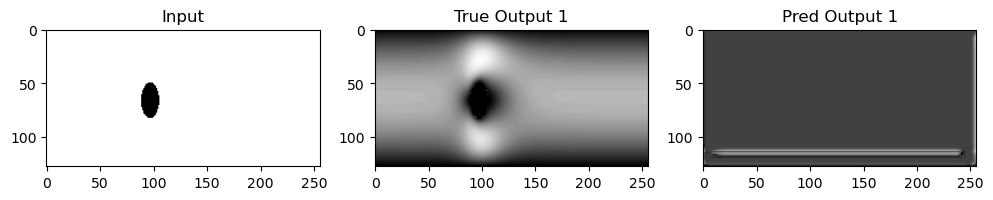

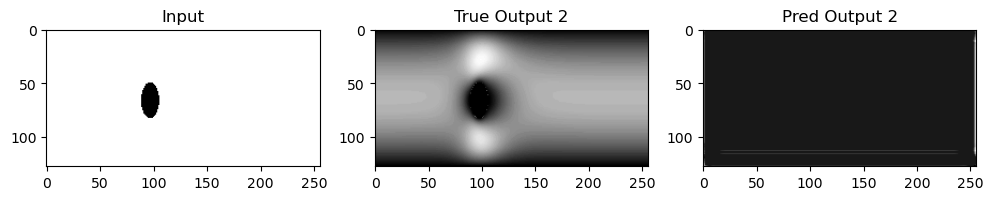

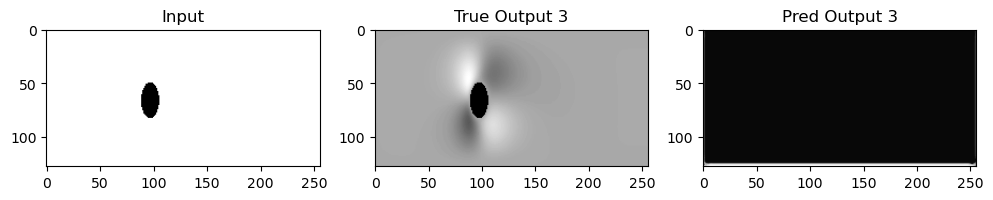

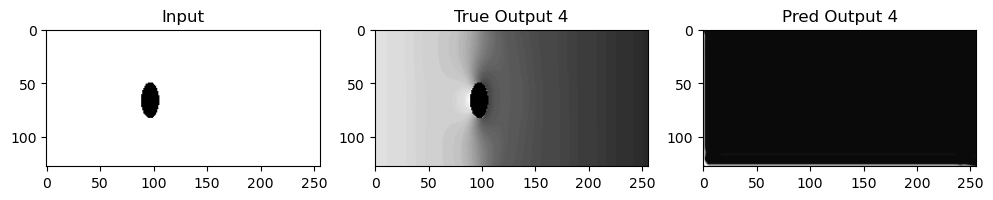

2025-05-14 17:31:25.112519: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [18]:
for x_test,y_true in final_test.take(1):
    for i in range(4):
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(x_test[0],cmap='gray')
        axs[0].set_title("Input")

        axs[1].imshow(y_true[i][0],cmap='gray')
        axs[1].set_title(f"True Output {i+1}")

        axs[2].imshow(y_pred[i][0],cmap='gray')
        axs[2].set_title(f"Pred Output {i+1}")
        plt.show()
        

In [ ]:
v_true = y_batch[0]  # [batch, H, W, 2]
vx_true = y_batch[1]  # [batch, H, W, 1]
vy_true = y_batch[2]  # [batch, H, W, 1]
p_true = y_batch[3]  # [batch, H, W, 1]

v_pred = y_pred[0][0]  # [H, W, 2]
p_pred = y_pred[1][0]  # [H, W, 1]


In [ ]:
# y_pred = [v_pred, p_pred]
v_true = y_batch[0]  # [batch, H, W, 2]
vx_true = y_batch[1]  # [batch, H, W, 1]
vy_true = y_batch[2]  # [batch, H, W, 1]
p_true = y_batch[3]  # [batch, H, W, 1]

v_pred = y_pred[0][0]  # [H, W, 2]
p_pred = y_pred[1][0]  # [H, W, 1]


In [ ]:
for x_test,y_true in final_test.take(1):
    y_pred = model.predict(x_test)
    for i in range(4):
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(x_test[0],cmap='gray')
        axs[0].set_title("Input")

        axs[1].imshow(y_true[i][0],cmap='gray')
        axs[1].set_title(f"True Output {i+1}")

        axs[2].imshow(y_pred[i][0],cmap='gray')
        axs[2].set_title(f"Pred Output {i+1}")
        plt.show()
        

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
    x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
    return x

def encoder_block(x, filters):
    c = conv_block(x, filters)
    p = layers.MaxPooling2D((2, 2))(c)
    return c, p

def decoder_block(x, skip, filters):
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x

def unet_with_3_decoders(input_shape=(128, 128, 1)):
    inputs = tf.keras.Input(input_shape)

    # Encoder
    c1, p1 = encoder_block(inputs, 16)
    c2, p2 = encoder_block(p1, 32)
    c3, p3 = encoder_block(p2, 64)

    # Bottleneck
    b = conv_block(p3, 128)

    # Decoder 1 (e.g., salida u)
    d1_1 = decoder_block(b, c3, 64)
    d1_2 = decoder_block(d1_1, c2, 32)
    d1_3 = decoder_block(d1_2, c1, 16)
    out_u = layers.Conv2D(1, 1, activation='linear', name='u_output')(d1_3)

    # Decoder 2 (e.g., salida v)
    d2_1 = decoder_block(b, c3, 64)
    d2_2 = decoder_block(d2_1, c2, 32)
    d2_3 = decoder_block(d2_2, c1, 16)
    out_v = layers.Conv2D(1, 1, activation='linear', name='v_output')(d2_3)

    # Decoder 3 (e.g., salida presión)
    d3_1 = decoder_block(b, c3, 64)
    d3_2 = decoder_block(d3_1, c2, 32)
    d3_3 = decoder_block(d3_2, c1, 16)
    out_p = layers.Conv2D(1, 1, activation='linear', name='p_output')(d3_3)

    # Modelo final
    model = Model(inputs, [out_u, out_v, out_p])
    return model
